In [13]:
import matplotlib

%matplotlib inline

In [14]:
# The first thing to do is to import the relevant packages
# that I will need for my script, 
# these include the Numpy (for maths and arrays)
# and csv for reading and writing csv files
# If i want to use something from this I need to call 
# csv.[function] or np.[function] first

import csv as csv 
import numpy as np

# Open up the csv file in to a Python object
data_all = []
with open('events_pdloire.csv', encoding="utf8") as train_file:
    csv_reader = csv.reader(train_file, delimiter=';', quotechar='"')
    for row in csv_reader:
        data_all.append(row)
data_all = np.array(data_all)
data = data_all[1::]


## Initiation LDA model 
Nota Bene : Because this is unsupervised learning, you can't just arbitrarily set a number of topics.  Its similar to K-means clustering, you have to find the ideal number of centroids.  And in similar ways, there are methods to help you do this, but its not perfect.


In [15]:
import pandas as pd
import re

data = pd.read_csv('events_pdloire.csv', sep=';')

#population_age = df.Link.astype(np.float)
#print(data.Description)
#print(data.Details)

df = data[['Description','Details']]

df[0:10]


,Description,Details
0,Comment le numérique peut nous aider à fluidif...,Dans un monde où tous les secteurs sont transf...
1,Village des sciences d'Angers,NaN
2,"Rencontre autour des nouveaux usages, de la pa...",Que recouvre aujourd’hui la notion de particip...
3,"En 2015, on fêtait la première détection d'une...","En 2015, on fêtait la première détection d'une..."
4,Il sera proposé aux jeunes élèves d'utiliser l...,Il sera proposé aux jeunes élèves d'utiliser l...
5,Découvrez le monde fascinant des champignons,Venez découvrir le monde fascinant des champig...
6,Comment réduire la pollution lumineuse pour am...,Comment réduire la pollution lumineuse pour am...
7,"des recherches en cours seront présentées, ill...",Les plantes sont essentielles pour la vie sur ...
8,Des démonstrations d’impression 3D auront lieu...,"Née simultanément au Japon, en France et aux É..."
9,Vous êtes invités à réfléchir au destin partic...,Vous êtes invités à réfléchir au destin partic...


## Netoyage des données

LDA a besoin que chaque phrase soit découpé sous forme d'un tableau de mots minuscules. On réfléchira par la suite sur le fait que plusieurs

In [16]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')


for item in data.Description:
    if type(item) is str :
        raw = item.lower()
        token = tokenizer.tokenize(raw)
        #print(token)




In [17]:
from stop_words import get_stop_words

# create English stop words list
#en_stop = get_stop_words('en')

# create French stop words list
fr_stop = get_stop_words('fr')
fr_stop.append('nan')
fr_stop.append('s')
fr_stop.append('c')
fr_stop.append('http')
fr_stop.append('www')
fr_stop.append('nantes')
fr_stop.append('nantais')
fr_stop.append('nantaise')
fr_stop.append("com")
fr_stop.append("youtube")
fr_stop.append("facebook")
fr_stop.append('https')
fr_stop.append("fr")
fr_stop.append("lundi")
fr_stop.append("mardi")
fr_stop.append("mercredi")
fr_stop.append("jeudi")
fr_stop.append("vendredi")
fr_stop.append("samedi")
fr_stop.append("dimanche")
fr_stop.append("be");
fr_stop.append("v");
fr_stop.append("plus")
fr_stop.append("visite")
fr_stop.append("h")


print(fr_stop)


['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayez', 'ayons', 'bon', 'car', 'ce', 'ceci', 'cela', 'ces', 'cet', 'cette', 'ceux', 'chaque', 'ci', 'comme', 'comment', 'd', 'dans', 'de', 'dedans', 'dehors', 'depuis', 'des', 'deux', 'devoir', 'devrait', 'devrez', 'devriez', 'devrions', 'devrons', 'devront', 'dois', 'doit', 'donc', 'dos', 'droite', 'du', 'dès', 'début', 'dù', 'elle', 'elles', 'en', 'encore', 'es', 'est', 'et', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes', 'faire', 'fais', 'faisez', 'fait', 'faites', 'fois', 'font', 'force', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes', 'haut', 'ho

# Stop words
Certain parts of English speech, like conjunctions (“for”, “or”) or the word “the” are meaningless to a topic model. 
These terms are called stop words and need to be removed from our token list.

#### On enlève les STOP WORDS des phrases

In [ ]:

tokens_stop_serie = pd.Series()
i=0

for item in data.Description:
        raw = str(item) +' '+ str(data.Details[i])
        token = tokenizer.tokenize(raw.lower())
        stopped_tokens = [i for i in token if not i in fr_stop]
        tokens_stop_serie = tokens_stop_serie.set_value(i,stopped_tokens)
        #print(tokens_stop_serie[i])
        i+=1

        
tokens_stop_serie[0:10]


# Stemming
Stemming words is another common NLP technique to reduce topically similar words to their root. 
For example, “nantaise,” “nantes,” “nantais,” all have similar meanings; stemming reduces those terms to “nant” 
This is important for topic modeling, which would otherwise view those terms as separate entities and reduce 
their importance in the model

In [ ]:
import nltk
from nltk.stem.snowball import FrenchStemmer


stemmer=nltk.stem.SnowballStemmer('french')
#stemmer = FrenchStemmer()

tokens_stem_serie = pd.Series()
i = 0
# Create p_stemmer of class PorterStemmer
# p_stemmer = PorterStemmer()

for stop_word_token in tokens_stop_serie:
    # stem token
    stemmed_tokens = [stemmer.stem(i) for i in stop_word_token]
    tokens_stem_serie = tokens_stem_serie.set_value(i,stemmed_tokens)
    i += 1
    
tokens_stem_serie[0:10]



# Constructing a document-term matrix

In [ ]:
from gensim import corpora, models

dictionary = corpora.Dictionary(tokens_stem_serie)

corpus = [dictionary.doc2bow(token) for token in tokens_stem_serie]

# The tuples are (term ID, term frequency)
print(corpus[0])



## Applying the LDA model
corpus is a document-term matrix and now we’re ready to generate an LDA model:

Parameters:

num_topics: required. An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.
id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
passes: optional. The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.

In [25]:

ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

                                    

In [88]:
print(ldamodel.print_topics(num_topics=10, num_words=4))

[(0, '0.010*"musiqu" + 0.007*"rock" + 0.005*"scen" + 0.005*"group"'), (1, '0.014*"jardin" + 0.011*"siecl" + 0.009*"exposit" + 0.008*"libr"'), (2, '0.008*"entrepris" + 0.006*"présent" + 0.004*"industr" + 0.004*"projet"'), (3, '0.004*"group" + 0.004*"présent" + 0.004*"univers" + 0.003*"the"'), (4, '0.009*"découvr" + 0.006*"utilis" + 0.006*"cré" + 0.004*"contenu"')]


## Time to Test the model !


In [90]:

print(ldamodel.top_topics(corpus, num_words=5))
    

[([(0.0096838142015704311, 'musiqu'), (0.0073447281049178947, 'rock'), (0.0048136056626571335, 'scen'), (0.0047325999901999677, 'group'), (0.0046844670477632928, 'jazz')], -9.8215203104265942), ([(0.0083515792283856034, 'entrepris'), (0.0064889689255625419, 'présent'), (0.0044033117879505486, 'industr'), (0.0041041985818416529, 'projet'), (0.0037885969462532008, '2016')], -10.081467640119703), ([(0.014233067415823907, 'jardin'), (0.011332378850670091, 'siecl'), (0.0089490467476017709, 'exposit'), (0.0078167793388779529, 'libr'), (0.0070787529026439498, 'guid')], -10.246060327437798), ([(0.0092815627739202579, 'découvr'), (0.0063806654530117702, 'utilis'), (0.0056357465683065594, 'cré'), (0.0042229907569510958, 'contenu'), (0.0040316086266170099, 'contact')], -12.721008968395783), ([(0.0040909157295247762, 'group'), (0.0038462006110472112, 'présent'), (0.0038330397086012743, 'univers'), (0.0033117232114013764, 'the'), (0.003246432606810506, 'organis')], -15.139363855516146)]


In [92]:
import matplotlib.pyplot as plt

# use matplotlib style sheet
try:
    plt.style.use('ggplot')
except:
    # version of matplotlib might not be recent
    pass

ValueError: Can only tuple-index with a MultiIndex

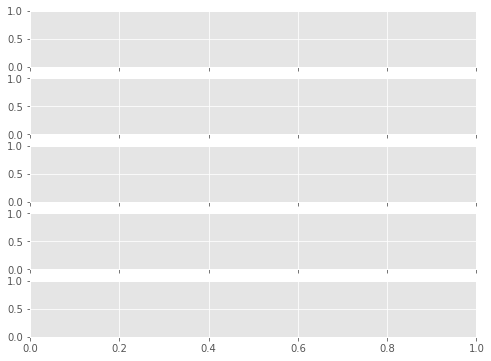

In [97]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for i, k in enumerate([0, 5, 9, 14, 19]):
    if tokens_stem_serie[k,:] != null :
        ax[i].stem(tokens_stem_serie[k,:], linefmt='b-',
                   markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(-50,4350)
        ax[i].set_ylim(0, 0.08)
        ax[i].set_ylabel("Prob")
        ax[i].set_title("topic {}".format(k))

ax[4].set_xlabel("word")

plt.tight_layout()
plt.show()

In [24]:

index = similarities.MatrixSimilarity(lda[corpus])
index.save("simIndex.index")

docname = "docs/the_doc.txt"
doc = open(docname, 'r').read()
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lda = lda[vec_bow]

sims = index[vec_lda]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)

NameError: name 'similarities' is not defined

In [ ]:
import numpy as np
import lda
import lda.datasets

X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()
titles = lda.datasets.load_reuters_titles()
X.shape
(395, 4258)
X.sum()
84010
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]     
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    



In [ ]:
doc_topic = model.doc_topic_
for i in range(10):
    print("{} (top topic: {})".format(titles[i], doc_topic[i].argmax()))
    